In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import albumentations as A
import cv2
from glob import glob
from tqdm import tqdm

## JigSaw Augmentations

In [7]:
class jigsaw_pipeline() :
    def __init__(self, color_jitter=False) :
        self.color_jitter = color_jitter
    
    def __call__(self, img) :
        h, w, c = img.shape
        
        # step 1. resize width or height to 256 with preserve the original aspect ratio.
        if h < w :
            resized_w = int(w / h * 256)
            img = cv2.resize(img, (256 , resized_w))

        elif w <= h :
            resized_h = int(h / w * 256)
            img = cv2.resize(img, (resized_h, 256))
        
        # step 2. Random crop size 225 x 225
        img = A.RandomCrop(225, 225)(image = img)['image']
        
        # step 3 and 4. split 3 x 3 grid of 75 x 75 pixels tiles and random crop 64 x 64
        for i in range(3) :
            for j in range(3) :
                crop_img = img[i*75 : (i * 75) + 75, j*75 : (j * 75) + 75, :]
                
                if i == 0 and j == 0 :    
                    tile_img = A.RandomCrop(64, 64)(image = crop_img)['image']
                else : 
                    tile_img = np.concatenate((tile_img, A.RandomCrop(64, 64)(image = crop_img)['image']),axis=2)
        
        return tile_img

In [16]:
img = cv2.imread('./data/1.jpg')
pipeline = jigsaw_pipeline()

tile = pipeline(img)
print(tile.shape)

(64, 64, 27)


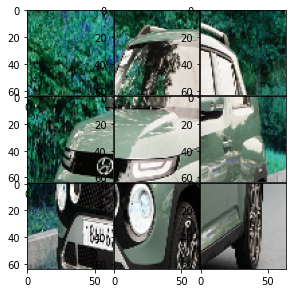

In [17]:
import matplotlib.pyplot as plt

img_ = np.array(tile, dtype=np.uint8)

fig, axs = plt.subplots(3, 3, figsize=(9,9))
axs = axs.flatten()
for i in range(9) :
    axs[i].imshow(img_[ :, :, i*3:(i+1)*3])
#     axs[idx].set_axis_off()
plt.subplots_adjust(left=0.3, bottom=0.3,  right=0.7 , top=0.7, wspace=0.01, hspace=0.01)
plt.show()

### tile shuffle

In [18]:
permu = [6, 4, 9, 8, 1, 7, 3, 2, 5]

shuffled_tile = np.zeros_like(tile)
for idx, num in enumerate(permu, start=1) :
    shuffled_tile[:, :, (idx-1)*3 : idx*3] = tile[:, :, (num-1) * 3 : num * 3]
print(shuffled_tile.shape)

(64, 64, 27)


[6, 4, 9, 8, 1, 7, 3, 2, 5]


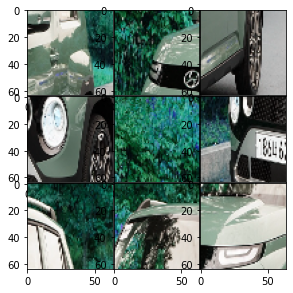

In [23]:
import matplotlib.pyplot as plt

img_ = shuffled_tile
print(permu)
fig, axs = plt.subplots(3, 3, figsize=(9,9))
axs = axs.flatten()
for i in range(9) :
    axs[i].imshow(img_[ :, :, i*3:(i+1)*3])
#     axs[idx].set_axis_off()
plt.subplots_adjust(left=0.3, bottom=0.3,  right=0.7 , top=0.7, wspace=0.01, hspace=0.01)
plt.show()